<a href="https://colab.research.google.com/github/ivanpalenciab/Cookflash/blob/master/1_XG_boost_EMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def busqueda(datos_entrenamiento,datos_validacion):
  CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]
  learning_rate = [0.01, 0.1, 0.2]
  max_depth = [2,3, 4, 5,6,7,8]
  subsample = [0.8, 0.9, 1.0]
  colsample_bytree = [0.7,0.8, 0.9, 1.0]

  errores_learning_rate = []
  errores_max_depth = {"i":{"j":[]}}
  errores = []

  X_train = datos_entrenamiento[CARACTERISTICAS]
  y_train =  datos_entrenamiento.PROMEDIO

  X_test = datos_validacion[CARACTERISTICAS]
  y_test = datos_validacion.PROMEDIO

  for i in learning_rate:
    for j in max_depth:
      for k in subsample:
        reg = xgb.XGBRegressor( base_score= None , booster= None ,
                              n_estimators= 1000 ,
                              early_stopping_rounds= 50 ,
                              subsample=k,
                              max_depth= j ,
                              learning_rate= i )


        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=0)
        y_predict = reg.predict(datos_validacion[CARACTERISTICAS])
        y_predict = pd.Series(y_predict)

        score = np.sqrt(mean_squared_error(y_predict,datos_validacion.Precio_Cierre))

        errores.append((i,j,k,score))


  indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])
  print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
  print("El índice de la tupla con el número más pequeño es:", indice)
  print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

In [ ]:
modo_1 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Modo_1.csv")
modo_2 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Modo_2.csv")
modo_3 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Modo_3.csv")
modo_4 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Modo_4.csv")
modo_5 = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Modo_5.csv")
residuo = pd.read_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/emd_modes/Residuo.csv")
modos = [modo_1,modo_2,modo_3,modo_4,modo_5,residuo]

for i in modos:
  i["FECHA"] = pd.to_datetime(i["FECHA"],format='%Y-%m-%d')
  i.set_index("FECHA", inplace=True)


In [ ]:
len(modo_2)

554

<Axes: xlabel='FECHA'>

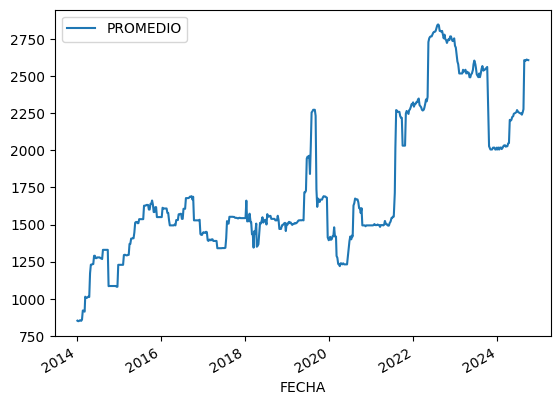

In [ ]:
datos_emd = modo_1 + modo_2 + modo_3 + modo_4 + modo_5 + residuo
#datos_emd = datos_emd.asfreq('W')
#datos_emd.interpolate(inplace=True)
datos_emd.plot()

In [ ]:
def add_lags(df,pasos):
    target_map = df['PROMEDIO'].to_dict()
    for i in range(pasos+1):
      df[f'retraso-{i}'] = df['PROMEDIO'].shift(i)
    df = df.drop(columns=["retraso-0"])
    df.dropna(inplace=True)
    return df

In [ ]:
PASOS = 7

In [ ]:
CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]

# Modelaremos el primer modo

In [ ]:
modo_1_values = modo_1.values
modo_1_values = modo_1_values.astype('float32')
modo_1_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_1_values = modo_1_values.reshape(-1, 1)
modo_1_escalado =  pd.DataFrame(modo_1_scaler.fit_transform(modo_1_values), columns=modo_1.columns,index=modo_1.index)
modo_1_sup = add_lags(modo_1_escalado, PASOS)
modo_1_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232,0.010940
2014-02-26,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632,0.008232
2014-03-07,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825,0.010632
2014-03-12,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434,0.020825
2014-03-19,-0.025976,0.158988,-0.189268,0.035904,0.172697,-0.107882,-0.092994,-0.020434


In [ ]:
total_datos=len(modo_1_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m1 = modo_1_sup[:division_entrenamiento]
datos_validacion_m1 = modo_1_sup[division_entrenamiento:division_validacion]
datos_testeo_m1 = modo_1_sup[division_validacion:total_datos]

In [ ]:
total_datos=len(modo_1.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_1[:division_entrenamiento]
datos_validacion = modo_1[division_entrenamiento:division_validacion]
datos_testeo = modo_1[division_validacion:total_datos]

In [ ]:
total_datos

554

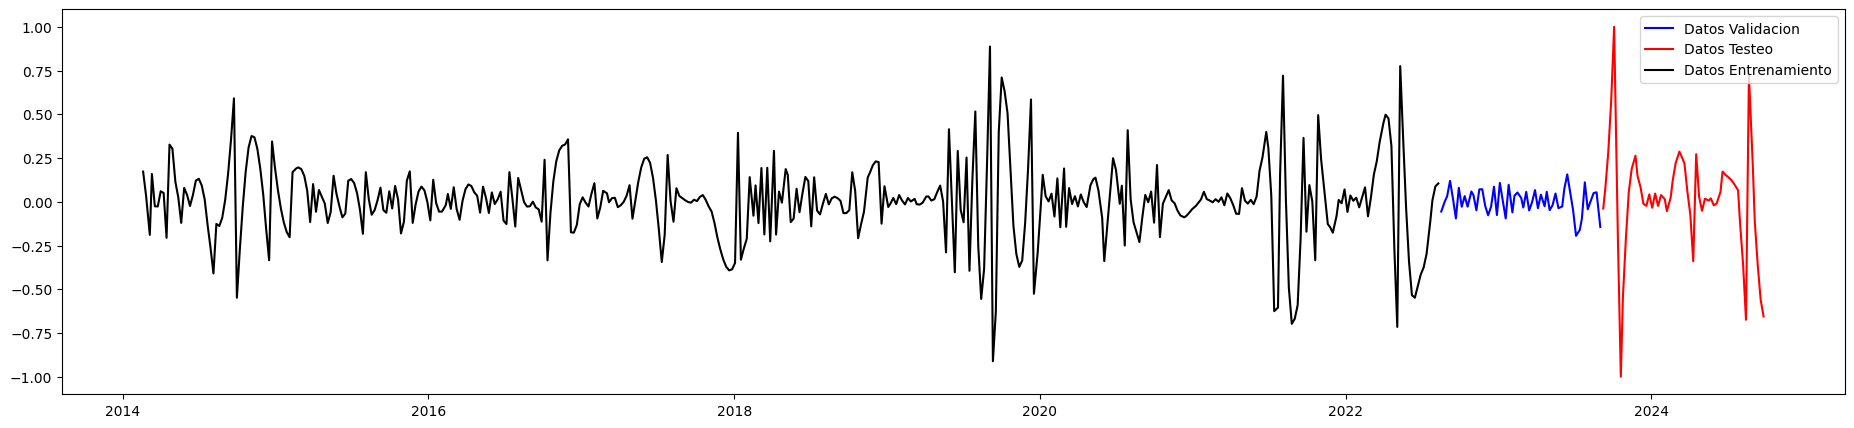

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento_m1[CARACTERISTICAS]
y_train =  datos_entrenamiento_m1.PROMEDIO

X_test = datos_validacion_m1[CARACTERISTICAS]
y_test = datos_validacion_m1.PROMEDIO

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=0)
      y_predict = reg.predict(datos_validacion_m1[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      #score = mean_absolute_percentage_error(y_predict,datos_validacion_m2.Precio_Cierre)
      score = np.sqrt(mean_squared_error(y_predict,datos_validacion_m1.PROMEDIO))

      errores.append((i,j,k,score))

In [ ]:
indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])

print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
print("El índice de la tupla con el número más pequeño es:", indice)
print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

El número más pequeño en la posición 3 de las tuplas es: 0.07554919
El índice de la tupla con el número más pequeño es: 18
el learning rate es 0.01 el max_depth es 8 y el subsample es 0.8


In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 19 , gap= 1 )
modo_1_sup = modo_1_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_1_sup[:division_validacion]) :
    train = modo_1_sup.iloc[train_idx]
    test = modo_1_sup.iloc[val_idx]

    OBJETIVO = 'PROMEDIO'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 8 ,
                           learning_rate= 0.01,
                            subsample= 0.8
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_modo_1 = reg.predict(X_test)
    validacion_modo_1 = pd.Series(validacion_modo_1)
    preds.append(validacion_modo_1)
    score = np.sqrt(mean_squared_error(validacion_modo_1,y_test))
    mae = mean_absolute_error(validacion_modo_1,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_1,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_1 = reg.predict(datos_validacion_m1[CARACTERISTICAS])
prediccion_modo_1 = reg.predict(datos_testeo_m1[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.1304348111152649 
Puntuaciones plegar: [0.06709793, 0.044747103, 0.2794594] 
Error Absoluto medio entre pliegues 0.09551829099655151
porcentaje de error absoluto medio entre pliegues 11.619967460632324


In [ ]:
score = np.sqrt(mean_squared_error(datos_testeo_m1[OBJETIVO],prediccion_modo_1))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.2816070020198822


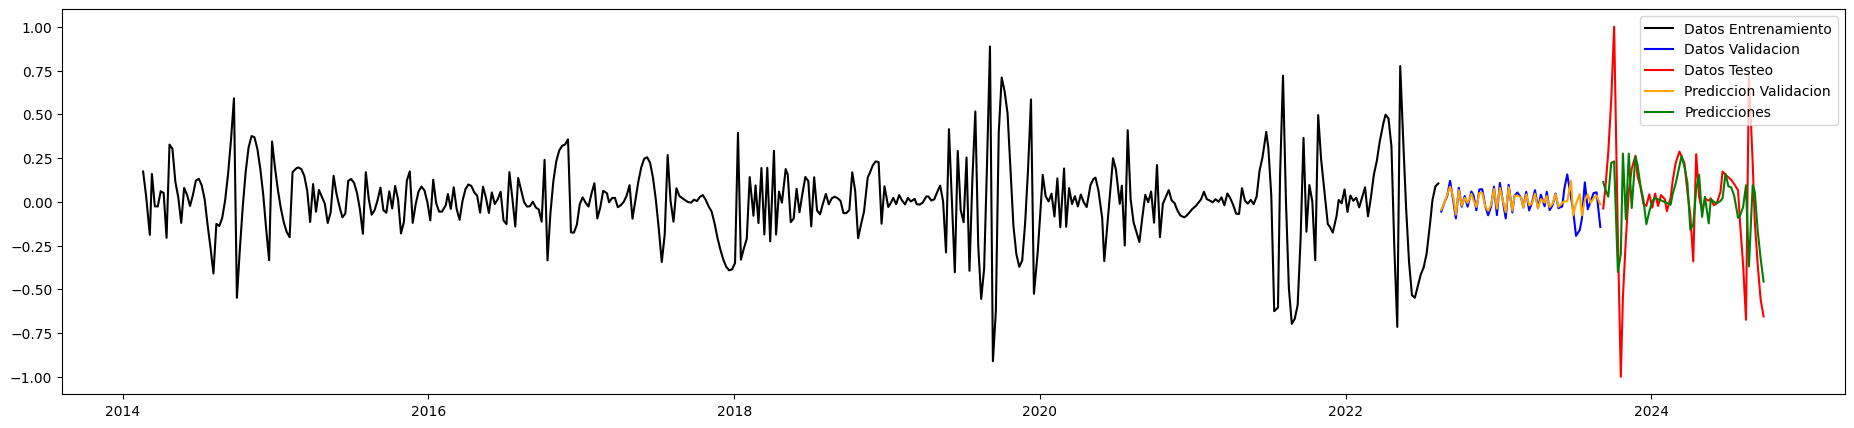

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m1.index,datos_entrenamiento_m1.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m1.index,datos_validacion_m1.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m1.index,datos_testeo_m1.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m1.index,validacion_modo_1,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m1.index,prediccion_modo_1,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_modo_1 = modo_1_scaler.inverse_transform(validacion_modo_1.reshape(-1, 1))
prediccion_modo_1 = modo_1_scaler.inverse_transform(prediccion_modo_1.reshape(-1, 1))

# Modelaremos el segundo modo

In [ ]:
modo_2_values = modo_2.values
modo_2_values = modo_2_values.astype('float32')
modo_2_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_2_values = modo_2_values.reshape(-1, 1)
modo_2_escalado =  pd.DataFrame(modo_2_scaler.fit_transform(modo_2_values), columns=modo_2.columns,index=modo_2.index)
modo_2_sup = add_lags(modo_2_escalado, PASOS)
modo_2_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543,-0.115907
2014-02-26,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002,-0.125543
2014-03-07,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698,-0.132002
2014-03-12,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053,-0.130698
2014-03-19,0.108054,0.090317,0.010561,-0.053753,-0.087502,-0.098992,-0.108631,-0.121053


In [ ]:
total_datos=len(modo_2_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m2 = modo_2_sup[:division_entrenamiento]
datos_validacion_m2 = modo_2_sup[division_entrenamiento:division_validacion]
datos_testeo_m2 = modo_2_sup[division_validacion:total_datos]

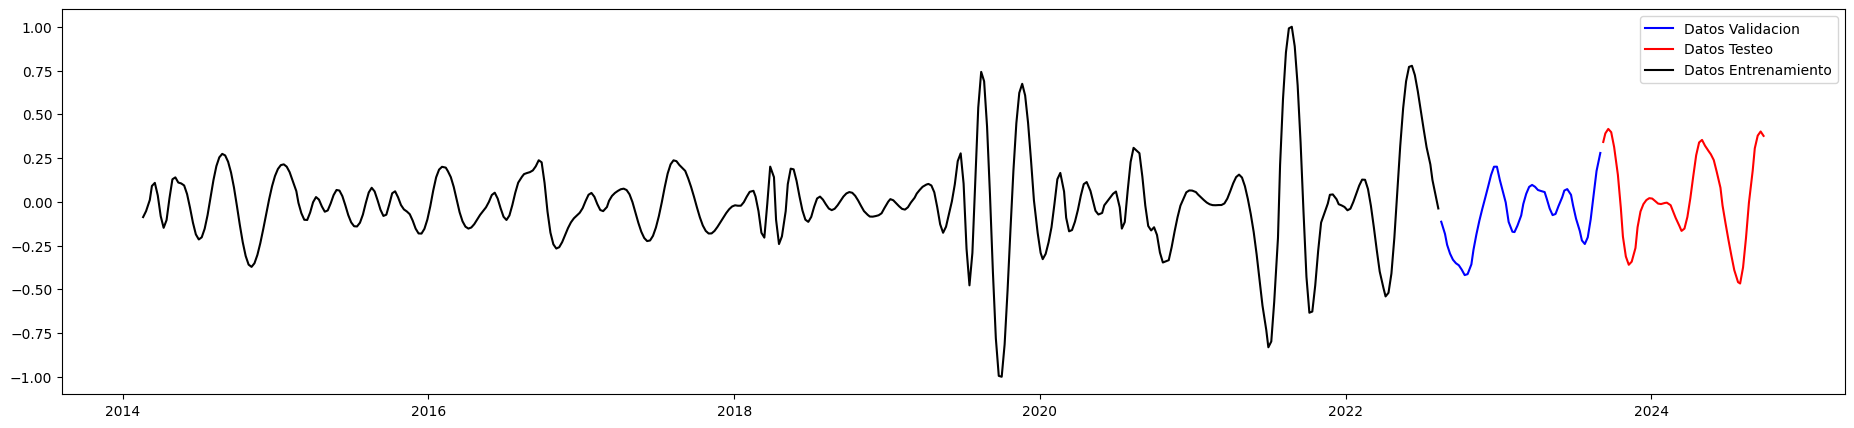

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento_m2[CARACTERISTICAS]
y_train =  datos_entrenamiento_m2.Precio_Cierre

X_test = datos_validacion_m2[CARACTERISTICAS]
y_test = datos_validacion_m2.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=0)
      y_predict = reg.predict(datos_validacion_m2[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      #score = mean_absolute_percentage_error(y_predict,datos_validacion_m2.Precio_Cierre)
      score = np.sqrt(mean_squared_error(y_predict,datos_validacion_m2.Precio_Cierre))

      errores.append((i,j,k,score))

In [ ]:
indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])

print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
print("El índice de la tupla con el número más pequeño es:", indice)
print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

El número más pequeño en la posición 3 de las tuplas es: 0.03291591
El índice de la tupla con el número más pequeño es: 18
el learning rate es 0.01 el max_depth es 8 y el subsample es 0.8


In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 19 , gap= 1 )
modo_2_sup = modo_2_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_2_sup[:division_validacion]) :
    train = modo_2_sup.iloc[train_idx]
    test = modo_2_sup.iloc[val_idx]

    OBJETIVO = 'PROMEDIO'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.01,
                            subsample= 1.0
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_modo_2 = reg.predict(X_test)
    validacion_modo_2 = pd.Series(validacion_modo_2)
    preds.append(validacion_modo_2)
    score = np.sqrt(mean_squared_error(validacion_modo_2,y_test))
    mae = mean_absolute_error(validacion_modo_2,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_2,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_2 = reg.predict(datos_validacion_m2[CARACTERISTICAS])
prediccion_modo_2 = reg.predict(datos_testeo_m2[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.04620618745684624 
Puntuaciones plegar: [0.06622903, 0.037523575, 0.034865957] 
Error Absoluto medio entre pliegues 0.03599204868078232
porcentaje de error absoluto medio entre pliegues 0.5473623275756836


In [ ]:
score = np.sqrt(mean_squared_error(datos_testeo_m2[OBJETIVO],prediccion_modo_2))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.08643069118261337


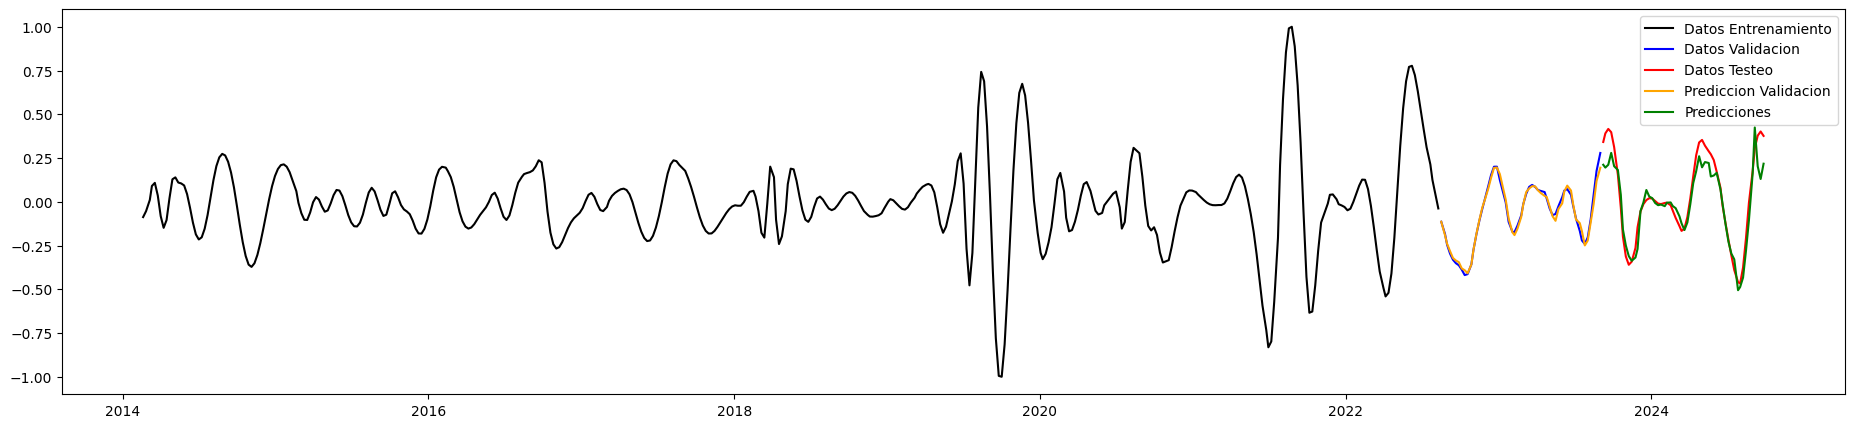

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m2.index,datos_entrenamiento_m2.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m2.index,datos_validacion_m2.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m2.index,datos_testeo_m2.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m2.index,validacion_modo_2,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m2.index,prediccion_modo_2,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_modo_2 = modo_2_scaler.inverse_transform(validacion_modo_2.reshape(-1, 1))
prediccion_modo_2 = modo_2_scaler.inverse_transform(prediccion_modo_2.reshape(-1, 1))

# Modelaremos el 3 modo

In [ ]:
modo_3_values = modo_3.values
modo_3_values = modo_3_values.astype('float32')
modo_3_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_3_values = modo_3_values.reshape(-1, 1)
modo_3_escalado =  pd.DataFrame(modo_3_scaler.fit_transform(modo_3_values), columns=modo_3.columns,index=modo_3.index)
modo_3_sup = add_lags(modo_3_escalado, PASOS)
modo_3_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.699930,-0.719922,-0.730921,-0.733665,-0.728900,-0.717387,-0.699896,-0.677202
2014-02-26,-0.670205,-0.699930,-0.719922,-0.730921,-0.733665,-0.728900,-0.717387,-0.699896
2014-03-07,-0.630007,-0.670205,-0.699930,-0.719922,-0.730921,-0.733665,-0.728900,-0.717387
2014-03-12,-0.578597,-0.630007,-0.670205,-0.699930,-0.719922,-0.730921,-0.733665,-0.728900
2014-03-19,-0.515235,-0.578597,-0.630007,-0.670205,-0.699930,-0.719922,-0.730921,-0.733665


In [ ]:
total_datos=len(modo_3_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m3 = modo_3_sup[:division_entrenamiento]
datos_validacion_m3 = modo_3_sup[division_entrenamiento:division_validacion]
datos_testeo_m3 = modo_3_sup[division_validacion:total_datos]

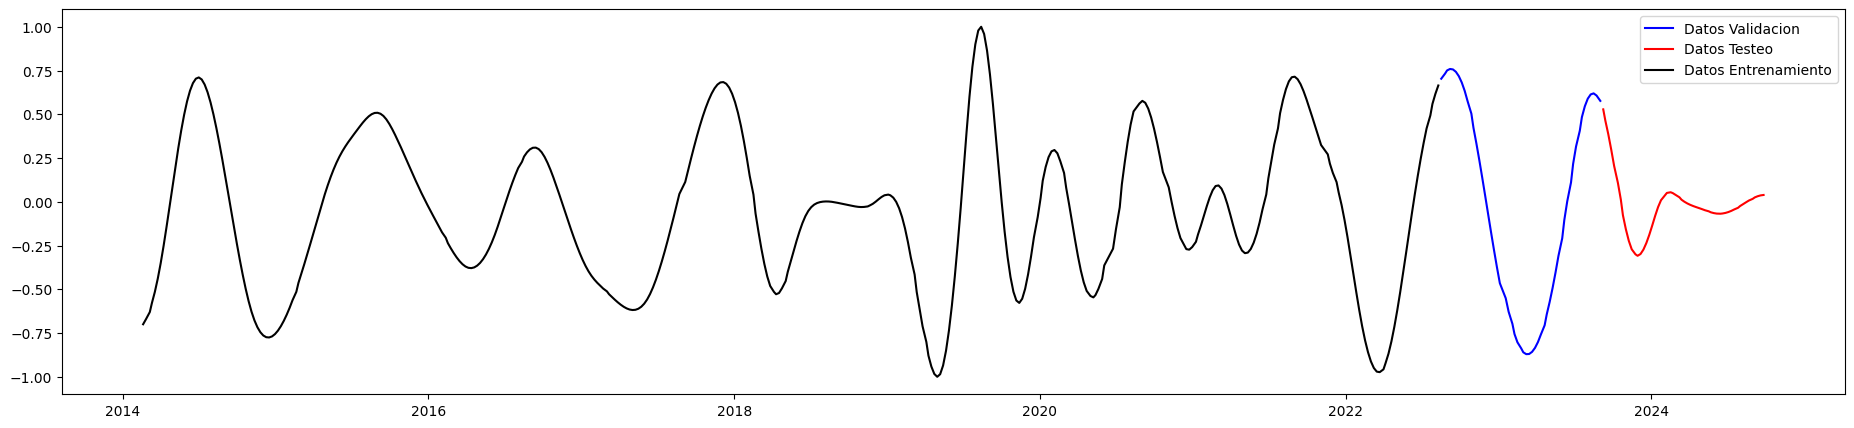

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_m3.index,datos_validacion_m3.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

Se hizo es una busque da hiperparametros y se encontro que los mejores hiperparametros son max depth 5 y learning rate 0.1

In [ ]:
learning_rate = [0.01, 0.1, 0.2]
max_depth = [2,3, 4, 5,6,7,8]
subsample = [0.8, 0.9, 1.0]
colsample_bytree = [0.7,0.8, 0.9, 1.0]

errores_learning_rate = []
errores_max_depth = {"i":{"j":[]}}
errores = []

X_train = datos_entrenamiento_m3[CARACTERISTICAS]
y_train =  datos_entrenamiento_m3.Precio_Cierre

X_test = datos_validacion_m3[CARACTERISTICAS]
y_test = datos_validacion_m3.Precio_Cierre

for i in learning_rate:
  for j in max_depth:
    for k in subsample:
      reg = xgb.XGBRegressor( base_score= None , booster= None ,
                            n_estimators= 1000 ,
                            early_stopping_rounds= 50 ,
                            subsample=k,
                            max_depth= j ,
                            learning_rate= i )


      reg.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              verbose=0)
      y_predict = reg.predict(datos_validacion_m3[CARACTERISTICAS])
      y_predict = pd.Series(y_predict)

      score = mean_absolute_percentage_error(y_predict,datos_validacion_m3.Precio_Cierre)

      errores.append((i,j,k,score))

In [ ]:
indice, valor_minimo = min(enumerate(errores), key=lambda x: x[1][3])

print("El número más pequeño en la posición 3 de las tuplas es:", valor_minimo[3])
print("El índice de la tupla con el número más pequeño es:", indice)
print( f"el learning rate es {errores[indice][0]} el max_depth es {errores[indice][1]} y el subsample es {errores[indice][2]}")

El número más pequeño en la posición 3 de las tuplas es: 0.119906746
El índice de la tupla con el número más pequeño es: 57
el learning rate es 0.2 el max_depth es 7 y el subsample es 0.8


In [ ]:
tss = TimeSeriesSplit(n_splits= 3 , test_size= 19 , gap= 1 )
modo_3_sup = modo_3_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_3_sup[:division_validacion]) :
    train = modo_3_sup.iloc[train_idx]
    test = modo_3_sup.iloc[val_idx]


    CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]
    OBJETIVO = 'PROMEDIO'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.01,
                            subsample= 1.0
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=0)

    validacion_modo_3 = reg.predict(X_test)
    validacion_modo_3 = pd.Series(validacion_modo_3)
    preds.append(validacion_modo_3)
    score = np.sqrt(mean_squared_error(validacion_modo_3,y_test))
    mae = mean_absolute_error(validacion_modo_3,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_3,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_3 = reg.predict(datos_validacion_m3[CARACTERISTICAS])
prediccion_modo_3 = reg.predict(datos_testeo_m3[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

Puntuación entre pliegues 0.02853236347436905 
Puntuaciones plegar: [0.028484907, 0.03606275, 0.021049432] 
Error Absoluto medio entre pliegues 0.02226620353758335
porcentaje de error absoluto medio entre pliegues 0.07382765412330627


In [ ]:
score = np.sqrt(mean_squared_error(datos_testeo_m3[OBJETIVO],prediccion_modo_3))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.018566574901342392


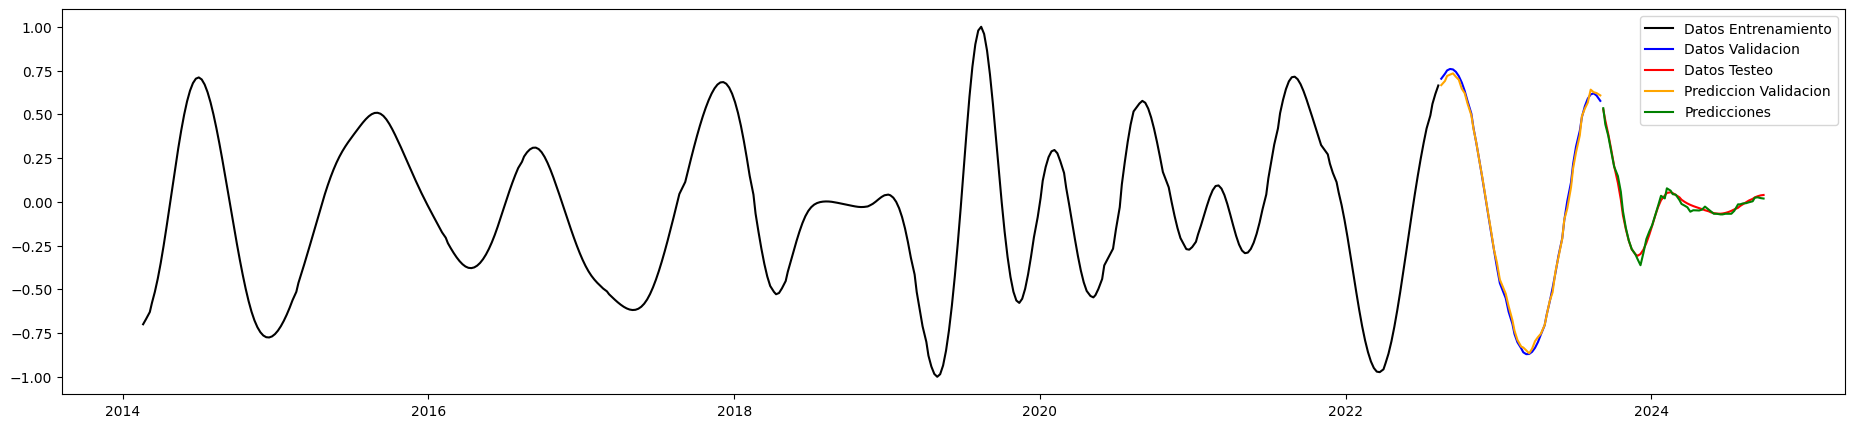

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m3.index,datos_entrenamiento_m3.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m3.index,datos_validacion_m3.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m3.index,datos_testeo_m3.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m3.index,validacion_modo_3,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m3.index,prediccion_modo_3,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_modo_3 = modo_3_scaler.inverse_transform(validacion_modo_3.reshape(-1, 1))
prediccion_modo_3 = modo_3_scaler.inverse_transform(prediccion_modo_3.reshape(-1, 1))

# modelaremos el modo 4

In [ ]:
modo_4_values = modo_4.values
modo_4_values = modo_4_values.astype('float32')
modo_4_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_4_values = modo_4_values.reshape(-1, 1)
modo_4_escalado =  pd.DataFrame(modo_4_scaler.fit_transform(modo_4_values), columns=modo_4.columns,index=modo_4.index)
modo_4_sup = add_lags(modo_4_escalado, PASOS)
modo_4_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,0.250257,0.251772,0.253309,0.254870,0.256460,0.258090,0.259776,0.261531
2014-02-26,0.248762,0.250257,0.251772,0.253309,0.254870,0.256460,0.258090,0.259776
2014-03-07,0.247285,0.248762,0.250257,0.251772,0.253309,0.254870,0.256460,0.258090
2014-03-12,0.245824,0.247285,0.248762,0.250257,0.251772,0.253309,0.254870,0.256460
2014-03-19,0.244376,0.245824,0.247285,0.248762,0.250257,0.251772,0.253309,0.254870


In [ ]:
total_datos=len(modo_4_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m4 = modo_4_sup[:division_entrenamiento]
datos_validacion_m4 = modo_4_sup[division_entrenamiento:division_validacion]
datos_testeo_m4 = modo_4_sup[division_validacion:total_datos]

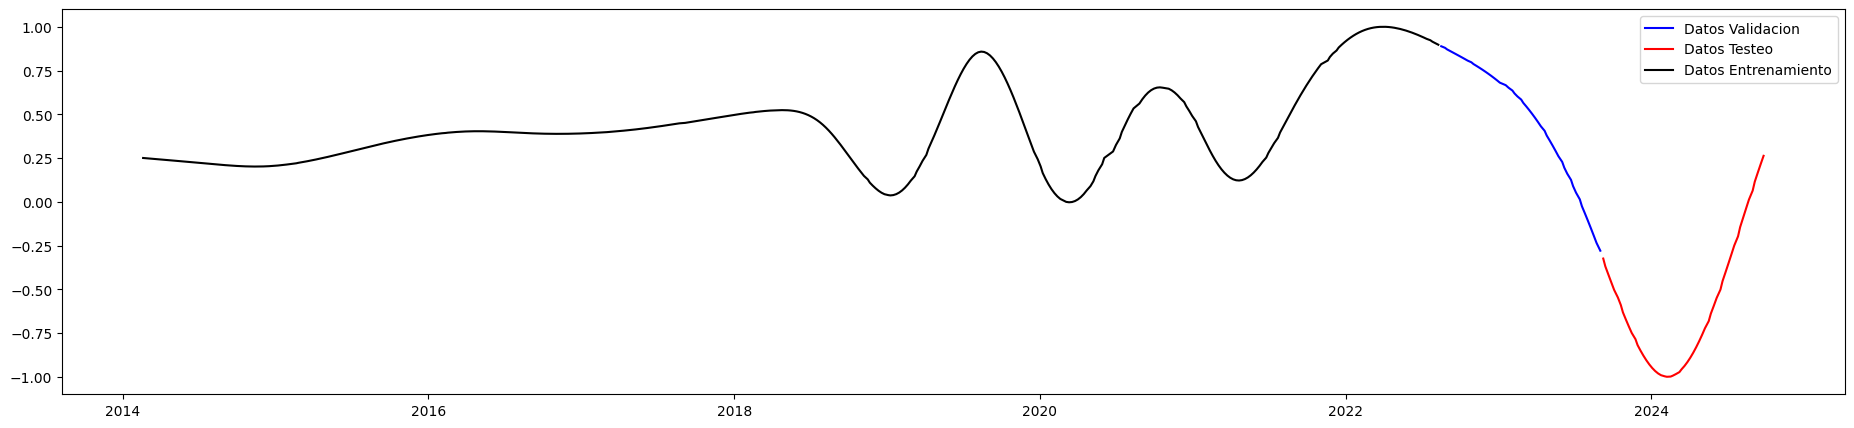

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_validacion_m4.index,datos_validacion_m4.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 19 , gap= 1 )
modo_4_sup = modo_4_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_4_sup[:division_validacion]) :
    train = modo_4_sup.iloc[train_idx]
    test = modo_4_sup.iloc[val_idx]


    CARACTERISTICAS = [ "retraso-1", "retraso-2",	"retraso-3",	"retraso-4",	"retraso-5",	"retraso-6",	"retraso-7"]
    OBJETIVO = 'PROMEDIO'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.01,
                            subsample= 1.0
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_4 = reg.predict(X_test)
    validacion_modo_4 = pd.Series(validacion_modo_4)
    preds.append(validacion_modo_4)
    score = np.sqrt(mean_squared_error(validacion_modo_4,y_test))
    mae = mean_absolute_error(validacion_modo_4,y_test)
    mape = mean_absolute_percentage_error(validacion_modo_4,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_4 = reg.predict(datos_validacion_m4[CARACTERISTICAS])
prediccion_modo_4 = reg.predict(datos_testeo_m4[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.23318	validation_1-rmse:0.41942
[100]	validation_0-rmse:0.08999	validation_1-rmse:0.14686
[200]	validation_0-rmse:0.03546	validation_1-rmse:0.05588
[300]	validation_0-rmse:0.01453	validation_1-rmse:0.02683
[400]	validation_0-rmse:0.00650	validation_1-rmse:0.02029
[500]	validation_0-rmse:0.00340	validation_1-rmse:0.01911
[600]	validation_0-rmse:0.00221	validation_1-rmse:0.01874
[700]	validation_0-rmse:0.00173	validation_1-rmse:0.01871
[800]	validation_0-rmse:0.00151	validation_1-rmse:0.01862
[900]	validation_0-rmse:0.00135	validation_1-rmse:0.01857
[999]	validation_0-rmse:0.00123	validation_1-rmse:0.01846
[0]	validation_0-rmse:0.24391	validation_1-rmse:0.18565
[100]	validation_0-rmse:0.09369	validation_1-rmse:0.06766
[200]	validation_0-rmse:0.03680	validation_1-rmse:0.02660
[300]	validation_0-rmse:0.01500	validation_1-rmse:0.01522
[400]	validation_0-rmse:0.00657	validation_1-rmse:0.01378
[467]	validation_0-rmse:0.00408	validation_1-rmse:0.01388
[0]	validation_0-r

In [ ]:
score = np.sqrt(mean_squared_error(datos_testeo_m4[OBJETIVO],prediccion_modo_4))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.7332203388214111


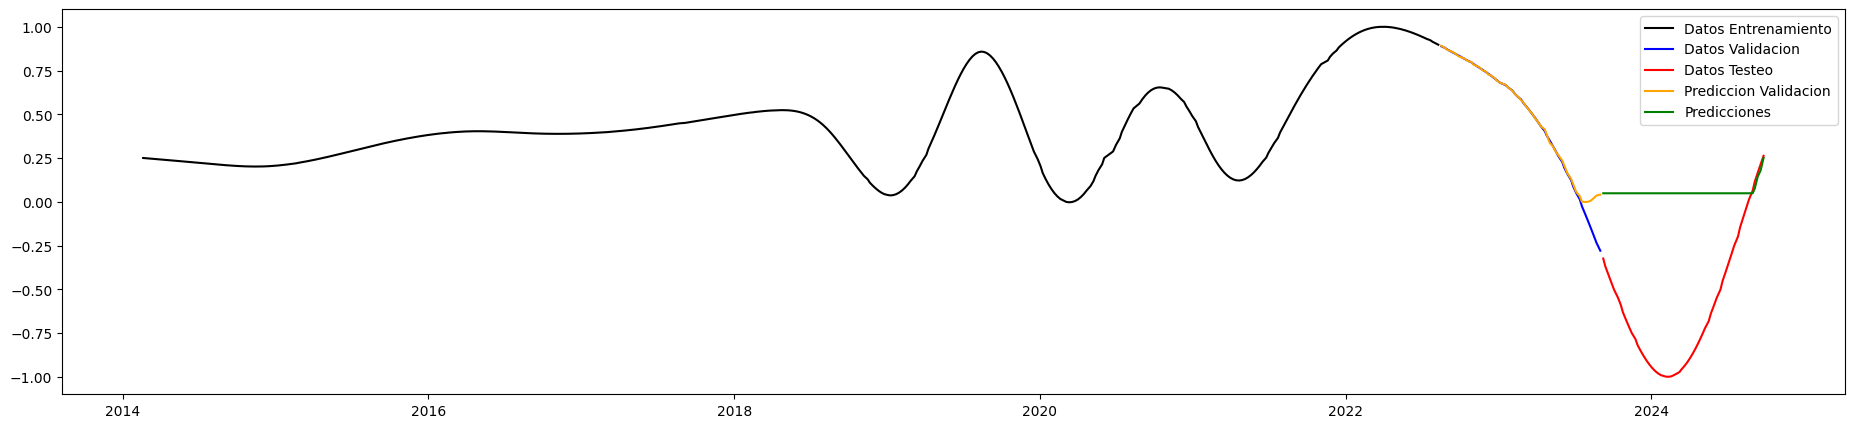

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m4.index,datos_entrenamiento_m4.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m4.index,datos_validacion_m4.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m4.index,datos_testeo_m4.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_validacion_m4.index,validacion_modo_4,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m4.index,prediccion_modo_4,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_modo_4 = modo_4_scaler.inverse_transform(validacion_modo_4.reshape(-1, 1))
prediccion_modo_4 = modo_4_scaler.inverse_transform(prediccion_modo_4.reshape(-1, 1))

# modelaremos el modo 5

In [ ]:
modo_5_values = modo_5.values
modo_5_values = modo_5_values.astype('float32')
modo_5_scaler = MinMaxScaler(feature_range=(-1, 1))
modo_5_values = modo_5_values.reshape(-1, 1)
modo_5_escalado =  pd.DataFrame(modo_5_scaler.fit_transform(modo_5_values), columns=modo_5.columns,index=modo_5.index)
modo_5_sup = add_lags(modo_5_escalado, PASOS)
modo_5_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.576900,-0.588460,-0.599975,-0.611443,-0.622860,-0.634221,-0.645525,-0.656767
2014-02-26,-0.565299,-0.576900,-0.588460,-0.599975,-0.611443,-0.622860,-0.634221,-0.645525
2014-03-07,-0.553660,-0.565299,-0.576900,-0.588460,-0.599975,-0.611443,-0.622860,-0.634221
2014-03-12,-0.541988,-0.553660,-0.565299,-0.576900,-0.588460,-0.599975,-0.611443,-0.622860
2014-03-19,-0.530285,-0.541988,-0.553660,-0.565299,-0.576900,-0.588460,-0.599975,-0.611443


In [ ]:
total_datos=len(modo_5_sup)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_m5 = modo_5_sup[:division_entrenamiento]
datos_validacion_m5 = modo_5_sup[division_entrenamiento:division_validacion]
datos_testeo_m5 = modo_5_sup[division_validacion:total_datos]

datos_entrenamiento_m5_values= datos_entrenamiento_m5.values
datos_validacion_m5_values = datos_validacion_m5.values
datos_testeo_m5_values = datos_testeo_m5.values

In [ ]:
total_datos=len(modo_5.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento = modo_5[:division_entrenamiento]
datos_validacion = modo_5[division_entrenamiento:division_validacion]
datos_testeo = modo_5[division_validacion:total_datos]

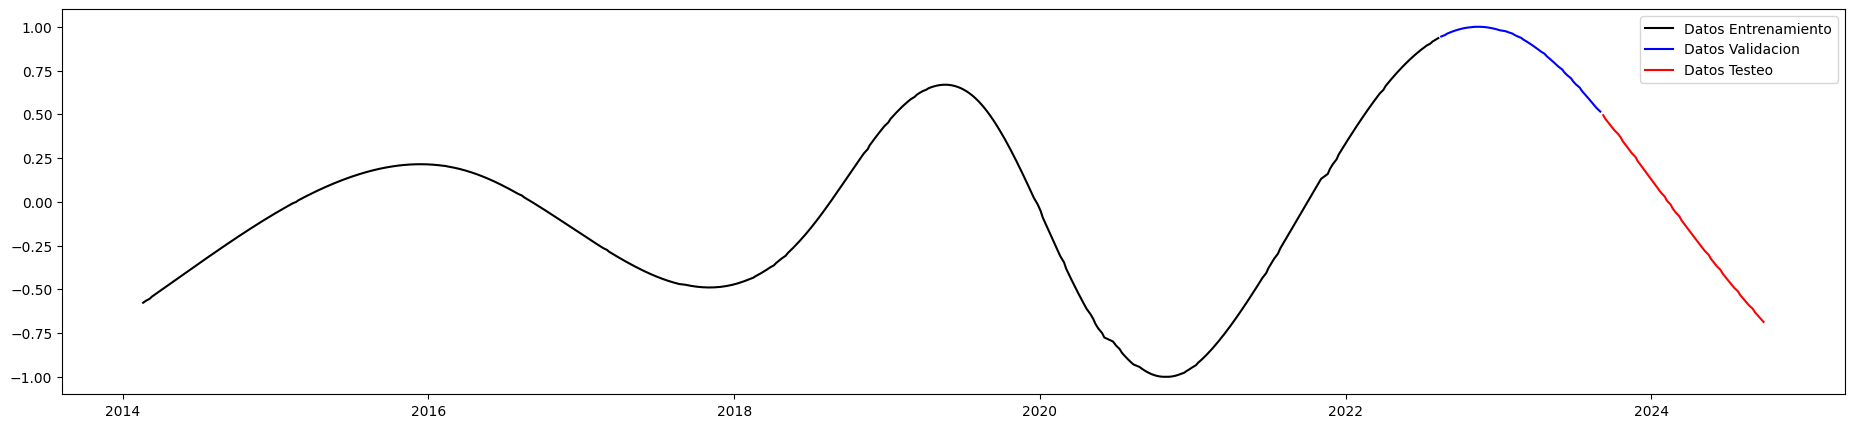

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 19 , gap= 1 )
modo_5_sup = modo_5_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(modo_5_sup[:division_validacion]) :
    train = modo_5_sup.iloc[train_idx]
    test = modo_5_sup.iloc[val_idx]

    OBJETIVO = 'PROMEDIO'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 6 ,
                           learning_rate= 0.2,
                            subsample=0.8
                            )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_modo_5 = reg.predict(X_test)
    validacion_modo_5 = pd.Series(validacion_modo_5)
    preds.append( validacion_modo_5)
    score = np.sqrt(mean_squared_error( validacion_modo_5,y_test))
    mae = mean_absolute_error( validacion_modo_5,y_test)
    mape = mean_absolute_percentage_error( validacion_modo_5,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_modo_5 = reg.predict(datos_validacion_m5[CARACTERISTICAS])
prediccion_modo_5 = reg.predict(datos_testeo_m5[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.37427	validation_1-rmse:0.89781
[100]	validation_0-rmse:0.00193	validation_1-rmse:0.03852
[103]	validation_0-rmse:0.00188	validation_1-rmse:0.03861
[0]	validation_0-rmse:0.40472	validation_1-rmse:0.71099
[66]	validation_0-rmse:0.00231	validation_1-rmse:0.02033
[0]	validation_0-rmse:0.42138	validation_1-rmse:0.43982
[63]	validation_0-rmse:0.00258	validation_1-rmse:0.02032
Puntuación entre pliegues 0.02014148235321045 
Puntuaciones plegar: [0.036892787, 0.009286821, 0.014244841] 
Error Absoluto medio entre pliegues 0.018137173727154732
porcentaje de error absoluto medio entre pliegues 0.023026974871754646


In [ ]:
score = np.sqrt(mean_squared_error(datos_testeo_m5[OBJETIVO],prediccion_modo_5))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.022609548643231392


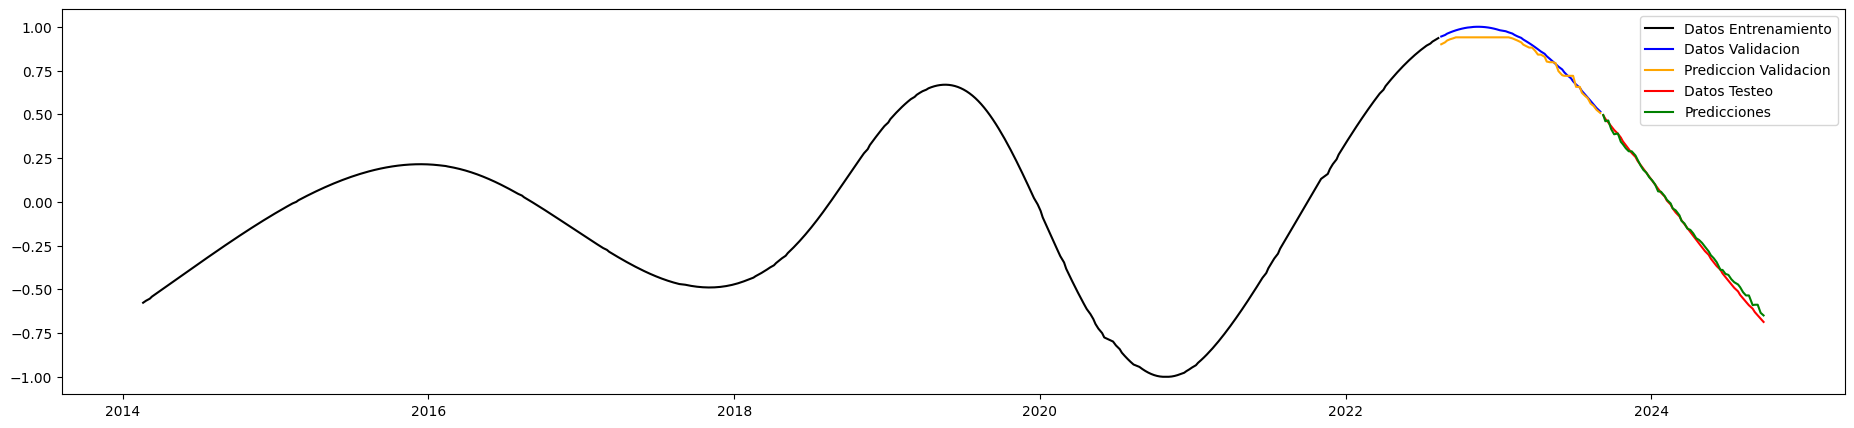

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_m5.index,datos_entrenamiento_m5.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_m5.index,datos_validacion_m5.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_m5.index,validacion_modo_5,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_m5.index,datos_testeo_m5.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_m5.index,prediccion_modo_5,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_modo_5 = modo_5_scaler.inverse_transform(validacion_modo_5.reshape(-1, 1))
prediccion_modo_5 = modo_5_scaler.inverse_transform(prediccion_modo_5.reshape(-1, 1))

# Modelaremos el residuo

In [ ]:
residuo_values = residuo.values
residuo_values = residuo_values.astype('float32')
residuo_scaler = MinMaxScaler(feature_range=(-1, 1))
residuo_values = residuo_values.reshape(-1, 1)
residuo_escalado =  pd.DataFrame(residuo_scaler.fit_transform(residuo_values), columns=residuo.columns,index=residuo.index)
residuo_sup = add_lags(residuo_escalado, PASOS)
residuo_sup.head(5)

,PROMEDIO,retraso-1,retraso-2,retraso-3,retraso-4,retraso-5,retraso-6,retraso-7
FECHA,,,,,,,,
2014-02-19,-0.973420,-0.977216,-0.981014,-0.984812,-0.988610,-0.992407,-0.996204,-1.000000
2014-02-26,-0.969625,-0.973420,-0.977216,-0.981014,-0.984812,-0.988610,-0.992407,-0.996204
2014-03-07,-0.965831,-0.969625,-0.973420,-0.977216,-0.981014,-0.984812,-0.988610,-0.992407
2014-03-12,-0.962039,-0.965831,-0.969625,-0.973420,-0.977216,-0.981014,-0.984812,-0.988610
2014-03-19,-0.958249,-0.962039,-0.965831,-0.969625,-0.973420,-0.977216,-0.981014,-0.984812


In [ ]:
total_datos=len(residuo_sup)

porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)


datos_entrenamiento_residuo = residuo_sup[:division_entrenamiento]
datos_validacion_residuo = residuo_sup[division_entrenamiento:division_validacion]
datos_testeo_residuo= residuo_sup[division_validacion:total_datos]

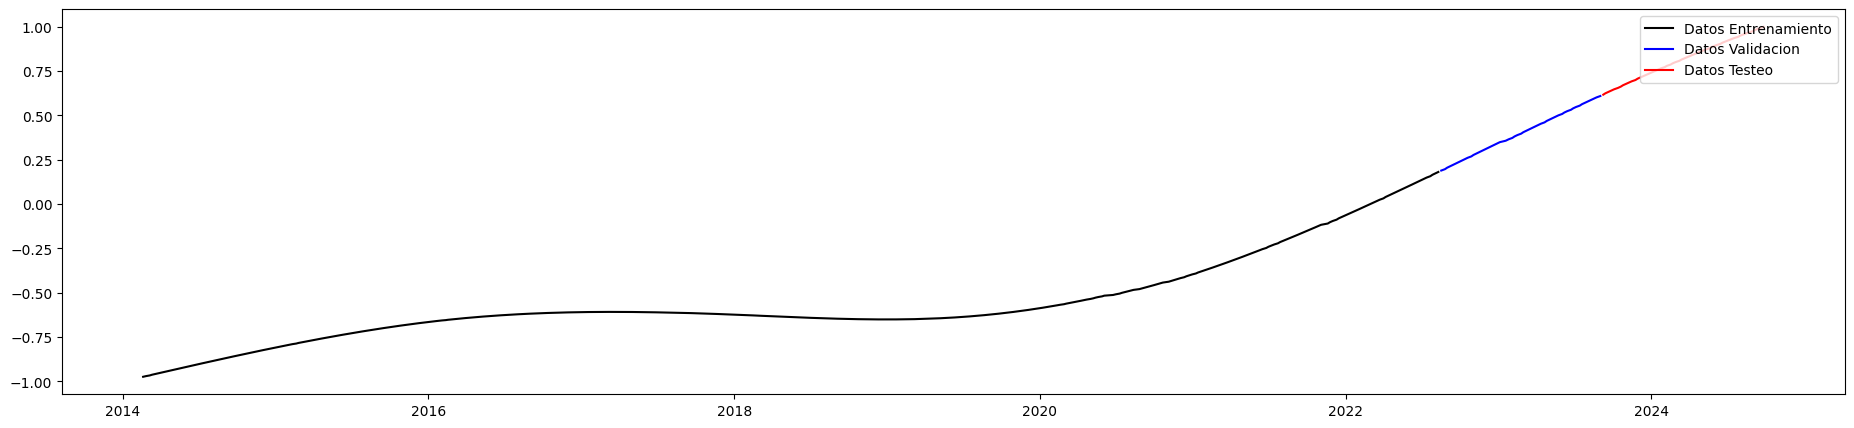

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
#ejecutando el modelo de aprendizaje automático
tss = TimeSeriesSplit(n_splits= 3 , test_size= 19 , gap= 1 )
residuo = residuo_sup.sort_index()


fold = 0
preds = []
puntuaciones = []
mapes = []
maes =[]
for train_idx, val_idx in tss.split(residuo_sup[:division_validacion]) :
    train = residuo_sup.iloc[train_idx]
    test = residuo_sup.iloc[val_idx]



    OBJETIVO = 'PROMEDIO'

    X_train = train[CARACTERISTICAS]
    y_train = train[OBJETIVO]

    X_test = test[CARACTERISTICAS]
    y_test = test[OBJETIVO]

    reg = xgb.XGBRegressor( base_score= None , booster= None ,
                           n_estimators= 1000 ,
                           early_stopping_rounds= 50 ,
                           max_depth= 4 ,
                           learning_rate= 0.1,
                            subsample=0.8)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    validacion_residuo = reg.predict(X_test)
    validacion_residuo = pd.Series(validacion_residuo)
    preds.append(validacion_residuo)
    score = np.sqrt(mean_squared_error(validacion_residuo,y_test))
    mae = mean_absolute_error(validacion_residuo,y_test)
    mape = mean_absolute_percentage_error(validacion_residuo,y_test)
    puntuaciones.append(score)
    mapes.append(mape)
    maes.append(mae)
validacion_residuo = reg.predict(datos_validacion_residuo[CARACTERISTICAS])
prediccion_residuo = reg.predict(datos_testeo_residuo[CARACTERISTICAS])

#imprimir puntuaciones para cada pliegue
print ( f'Puntuación entre pliegues {np.mean(puntuaciones)} ' )
print ( f'Puntuaciones plegar: {puntuaciones} ' )
print(f"Error Absoluto medio entre pliegues {np.mean(maes)}")
print(f"porcentaje de error absoluto medio entre pliegues {np.mean(mapes)}")

[0]	validation_0-rmse:0.21376	validation_1-rmse:0.74728
[100]	validation_0-rmse:0.00203	validation_1-rmse:0.10562
[176]	validation_0-rmse:0.00189	validation_1-rmse:0.10454
[0]	validation_0-rmse:0.25428	validation_1-rmse:0.85691
[100]	validation_0-rmse:0.00219	validation_1-rmse:0.10605
[200]	validation_0-rmse:0.00203	validation_1-rmse:0.10484
[252]	validation_0-rmse:0.00201	validation_1-rmse:0.10567
[0]	validation_0-rmse:0.29745	validation_1-rmse:0.96157
[100]	validation_0-rmse:0.00239	validation_1-rmse:0.10364
[178]	validation_0-rmse:0.00225	validation_1-rmse:0.10392
Puntuación entre pliegues 0.10356787592172623 
Puntuaciones plegar: [0.10381025, 0.10415637, 0.102737024] 
Error Absoluto medio entre pliegues 0.09402022510766983
porcentaje de error absoluto medio entre pliegues 0.39573171734809875


In [ ]:
score = np.sqrt(mean_squared_error(datos_testeo_residuo[OBJETIVO],prediccion_residuo))

print(f"El error Cuadratico medio del modelo es {score}")

El error Cuadratico medio del modelo es 0.38569673895835876


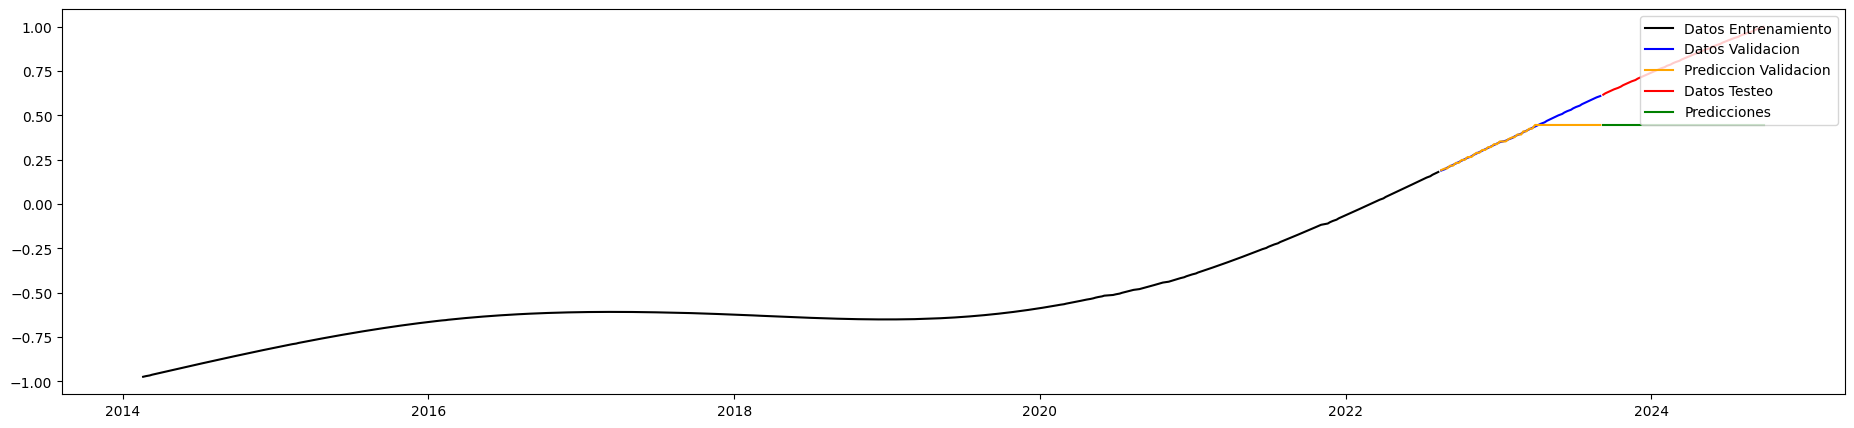

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento_residuo.index,datos_entrenamiento_residuo.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion_residuo.index,datos_validacion_residuo.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_validacion_residuo.index,validacion_residuo,color='orange',label = 'Prediccion Validacion')
ax.plot(datos_testeo_residuo.index,datos_testeo_residuo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo_residuo.index,prediccion_residuo,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion_residuo = residuo_scaler.inverse_transform(validacion_residuo.reshape(-1, 1))
prediccion_residuo = residuo_scaler.inverse_transform(prediccion_residuo.reshape(-1, 1))

# Ensemble
vamos a hacer el ensemble de todos los modelos para obtener el modelo final

In [ ]:
predicciones_emd = prediccion_modo_1 + prediccion_modo_2 + prediccion_modo_3 + prediccion_modo_4 + prediccion_modo_5 + prediccion_residuo

In [ ]:
total_datos=len(datos_emd.PROMEDIO)
porcentaje_entrenamiento, porcentaje_validacion = 0.8,0.1
division_entrenamiento = int(total_datos*porcentaje_entrenamiento)
division_validacion = division_entrenamiento + int(porcentaje_validacion*total_datos)

datos_entrenamiento = datos_emd[:division_entrenamiento]
datos_validacion = datos_emd[division_entrenamiento:division_validacion]
datos_testeo = datos_emd[division_validacion:total_datos]

Metricas validacion

In [ ]:
validacion = validacion_modo_1 + validacion_modo_2 + validacion_modo_3 + validacion_modo_4 + validacion_modo_5 + validacion_residuo
recm_validacion = np.sqrt(mean_squared_error(validacion,datos_validacion.PROMEDIO[:-1]))
eam_validacion = mean_absolute_error( validacion,datos_validacion.PROMEDIO[:-1])
EPAM_validacion = mean_absolute_percentage_error( validacion,datos_validacion.PROMEDIO[:-1])


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm_validacion} ' )
print ( f'el error absoluto medio del modelo es: {eam_validacion} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM_validacion}")

La raiz del error cuadratico medio del modelo es: 39.9284470762866 
el error absoluto medio del modelo es: 30.663140190972367 
Error porcentual absoluto medio del modelo es: 0.011988299697395467


Metricas de testeo del modelo

In [ ]:
recm = np.sqrt(mean_squared_error( predicciones_emd,datos_testeo.PROMEDIO))
eam = mean_absolute_error( predicciones_emd,datos_testeo.PROMEDIO)
EPAM = mean_absolute_percentage_error(predicciones_emd,datos_testeo.PROMEDIO)


#Imprimir las metricas de validacion del modelo
print ( f'La raiz del error cuadratico medio del modelo es: {recm} ' )
print ( f'el error absoluto medio del modelo es: {eam} ' )
print(f"Error porcentual absoluto medio del modelo es: {EPAM}")

La raiz del error cuadratico medio del modelo es: 235.79432013301826 
el error absoluto medio del modelo es: 198.68424987792918 
Error porcentual absoluto medio del modelo es: 0.09156727992048583


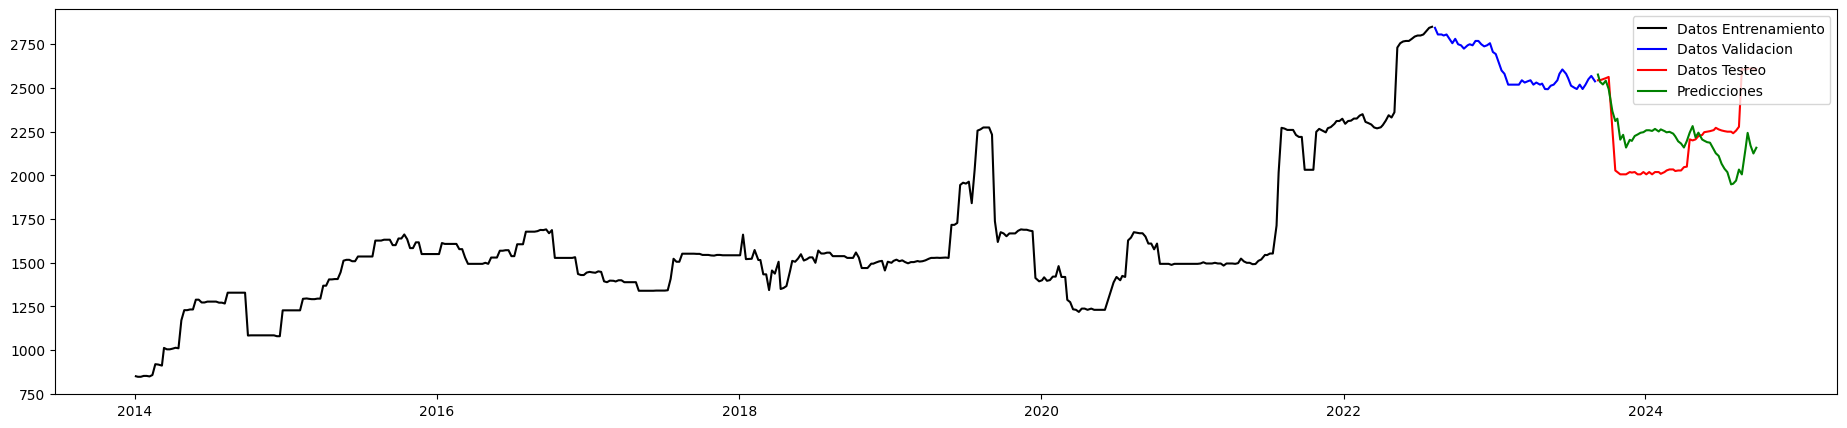

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_entrenamiento.index,datos_entrenamiento.PROMEDIO,color='black',label = 'Datos Entrenamiento')
ax.plot(datos_validacion.index,datos_validacion.PROMEDIO,color='blue',label = 'Datos Validacion')
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
#ax.plot(datos_validacion.index,validacion,color='orange',label = 'Datos Testeo')
ax.plot(datos_testeo.index,predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

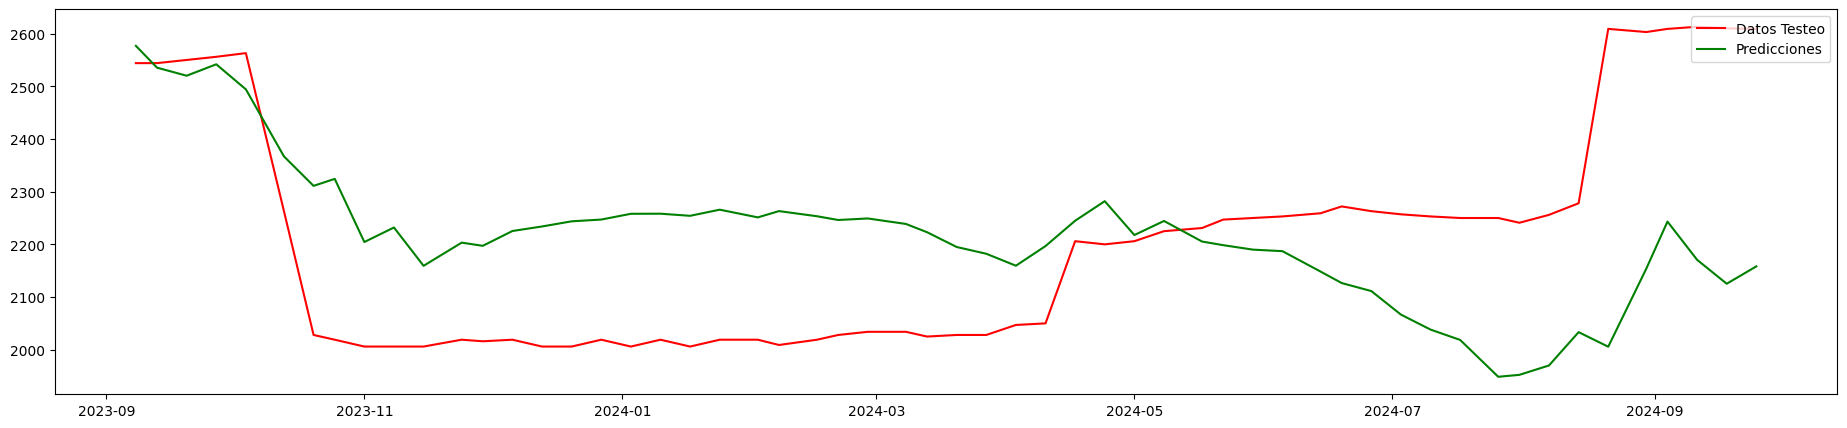

In [ ]:
fig, ax = plt.subplots(figsize=(23, 5))
ax.plot(datos_testeo.index,datos_testeo.PROMEDIO,color='red',label = 'Datos Testeo')
ax.plot(datos_testeo.index,predicciones_emd,color='Green',label = 'Predicciones')
ax.legend(loc = 'upper right')
plt.show()

In [ ]:
validacion =pd.DataFrame(validacion,index=datos_validacion.index[1:],columns=['PROMEDIO'])
testeo = pd.DataFrame(predicciones_emd,index=datos_testeo.index,columns=['PROMEDIO'])

In [ ]:
validacion.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Predicciones/EMD/validacion_xgboost.csv",index=True)
testeo.to_csv("/content/drive/MyDrive/prediccion_productos_agro/Fase 5 (Datos Atlantico)/Predicciones/EMD/testeo_xgboost.csv",index=True)